# 2nd order Quality Check

This scripts looks into the data in more depths. It can handle DAS data including data gaps. If this is too complicated, assume that there are no data gaps.

In [717]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd
import DASfuncs
import importlib
import sys

importlib.reload(DASfuncs)

<module 'DASfuncs' from '/Users/graeffd/Documents/projects/2022-25_SPI_GreenFjord/analysis/scripts/GreenFjord_DAS/DASfuncs.py'>

In [851]:
# get files
t_start = datetime.datetime(2023,6,1,22,20) #datetime.datetime(2023,7,6,23,40,53) 
t_end = datetime.datetime(2023,6,1,23,20) #datetime.datetime(2023,7,6,23,40,54) 
path = '../../../data/lab/SaltwaterTankTest/DAS_data'
# path = '/Users/graeffd/tmp/Samsung_2TB/ManualRecorders/data_2kiloHz'
files = DASfuncs.get_Onyx_h5(path, t_start, t_end)
print('{} files in directory'.format(len(files)))

55 files in directory


In [516]:
# get files manually
files = glob.glob('../../../data/lab/Onyx_temp_test/data_1Hz/*')
files.sort()

In [852]:
files = files[15:18]

In [853]:
# read the data
data_rec, t_rec, attrs = DASfuncs.read_Onyx_h5(files)

In [854]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)

In [855]:
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')
print('Data filles {:.2} GB of memory.'.format(sys.getsizeof(data_filled)/2**30))

Data filles 0.72 GB of memory.


Text(0.5, 0, 'Time [s]')

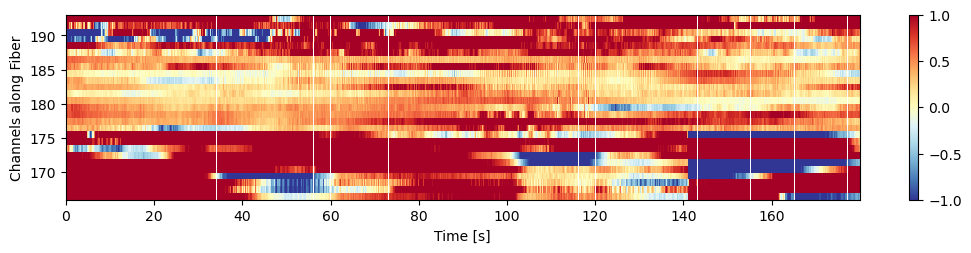

In [862]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

# left plot
im = ax.imshow(data_filled.T, aspect='auto',
             origin='lower',
             vmin=-1,#np.percentile(data[~np.isnan(data)],5),
             vmax=1,#np.percentile(data[~np.isnan(data)],95),
             extent=[0,data_filled.shape[0]/(attrs['PulseRate']), 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data_filled.shape[1]],
             cmap='RdYlBu_r',
             interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

## Time Series Data

In [863]:
# get data gaps
gap_list = DASfuncs.get_gaps(time_list, attrs)

Text(0.5, 0, 'Time')

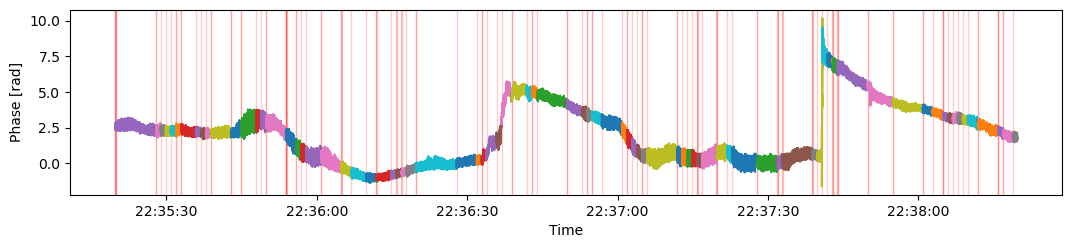

In [864]:
# plot time series with different colors indicating chunks of data
cha = 1
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, data_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

## Filtering

In [865]:
# filtering
sos = scipy.signal.butter(2, (10,100),'bandpass', fs=attrs['PulseRate'], output='sos') # frequency in m
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

Text(0.5, 0, 'Time')

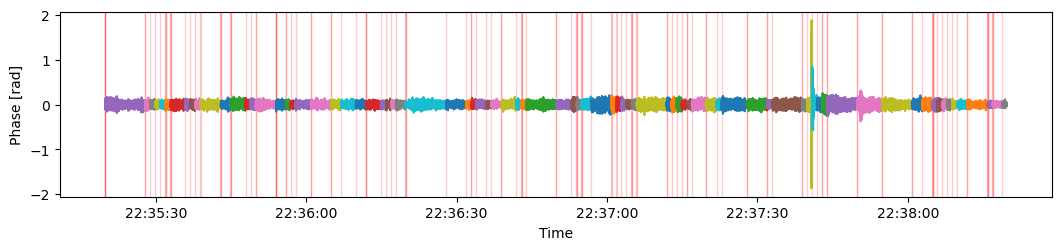

In [866]:
# plot filtered time series
cha = 0
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, filt_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

In [867]:
# fill filtered data into array
_, data_filt = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

In [868]:
# normalize data by variance
data_norm = data_filt / np.nanstd(data_filt, axis=0)[None,:]
data_norm = data_norm - np.nanmedian(data_norm, axis=0)

Text(0.5, 0, 'Time [s]')

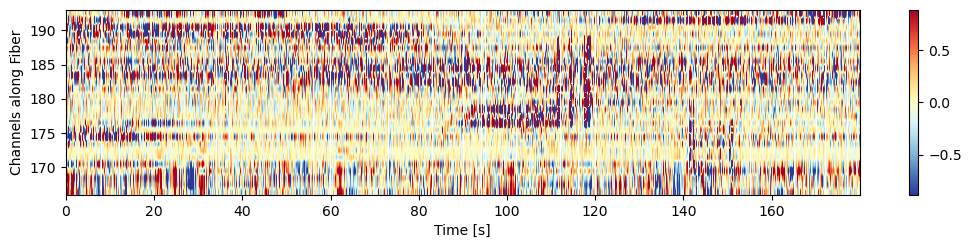

In [869]:
# plot filtered waterfall plot
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

im = ax.imshow(data_norm.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(data_norm[~np.isnan(data_norm)],10),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],90),
             extent=[0,data_norm.shape[0]/(attrs['PulseRate']), 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data_norm.shape[1]],
             cmap='RdYlBu_r',
             # interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

## Decimate from data lists

In [885]:
t_dec, data_dec = DASfuncs.decimate(time_list, data_list, 10, attrs)

Text(0.5, 0, 'Time [s]')

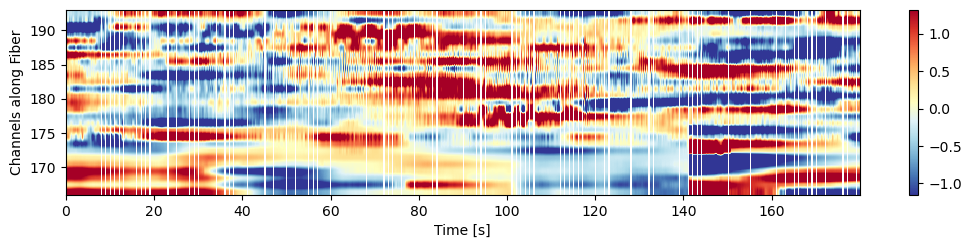

In [886]:
# plot filtered waterfall plot
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

data_norm = data_dec / np.nanstd(data_dec, axis=0)[None,:]
data_norm = data_norm - np.nanmedian(data_norm, axis=0)

im = ax.imshow(data_norm.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(data_norm[~np.isnan(data_norm)],10),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],90),
             extent=[0,(t_dec[-1]-t_dec[0]).total_seconds(),
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data_norm.shape[1]],
             cmap='RdYlBu_r',
             # interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

## Decimate from array filled with NaNs

In [ ]:
times_filled, data_filled

In [893]:
freqmax = 1000 # upper frequency of interes

In [913]:
gap_idxs = np.unique(np.where(np.isnan(data_filled))[0])
len(gap_idxs)

47055

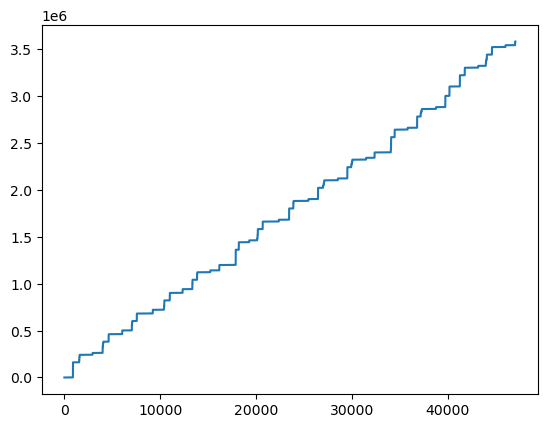

In [914]:
plt.plot(gap_idxs)

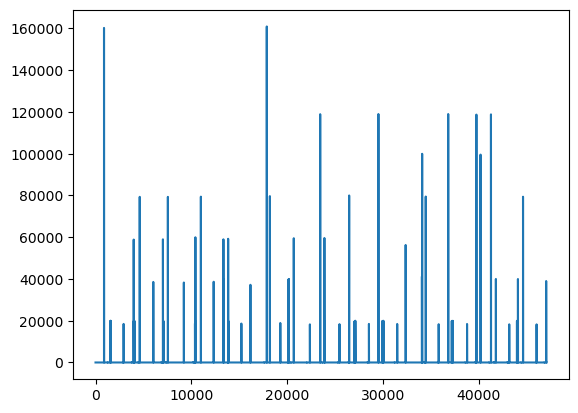

In [932]:
plt.plot(np.diff(gap_idx))

In [928]:
# where in the data are NaNs
gap_idxs = np.unique(np.where(np.isnan(data_filled))[0])

# where do continuous blocks of NaNs start
nanblock_start = gap_idxs[np.where(np.diff(gap_idxs)>1)[0]]

# where are continuous blocks of NaNs smaller than a certain length
np.where(np.diff(gap_idxs[np.where(np.diff(gap_idxs)>1)[0]]) < attrs['PulseRate']/freqmax/4.)[0]

array([    255,     511,     639,     895,  161535,  161919,  181247,
        201215,  221183,  242431,  242687,  262015,  262399,  321279,
        341247,  361215,  381567,  381823,  462335,  462591,  502015,
        502271,  561279,  581247,  601471,  601855,  682239,  682495,
        682623,  682879,  722175,  722559,  741247,  761215,  821503,
        821759,  902271,  902527,  942207, 1001215, 1041407, 1041663,
       1042047, 1101311, 1122559, 1142143, 1161215, 1199871, 1200255,
       1361535, 1442303, 1462015, 1462271, 1481343, 1521279, 1541247,
       1581439, 1581823, 1641343, 1662591, 1662975, 1682303, 1801471,
       1801727, 1861375, 1882623, 1882879, 1902207, 1902591, 1941247,
       2021759, 2041343, 2041727, 2061311, 2081279, 2102527, 2102783,
       2122239, 2241407, 2241663, 2261375, 2281343, 2301311, 2322431,
       2322815, 2342143, 2399871, 2400127, 2441343, 2461311, 2561535,
       2561791, 2642559, 2642943, 2662271, 2781439, 2781695, 2801407,
       2821375, 2841

In [ ]:
# i don't think the above approach will work, maybe try again the while loop approach

In [905]:
gap_idxs = np.unique(np.where(np.isnan(data_filled))[0])

all_nan_idxs = []
nan_idxs = []
# for i in range(len(gap_idxs)-1):

i=0
while (gap_idxs[i+1]-gap_idxs[i]) == 1:
    nan_idxs.append(i)
    i+=1

253

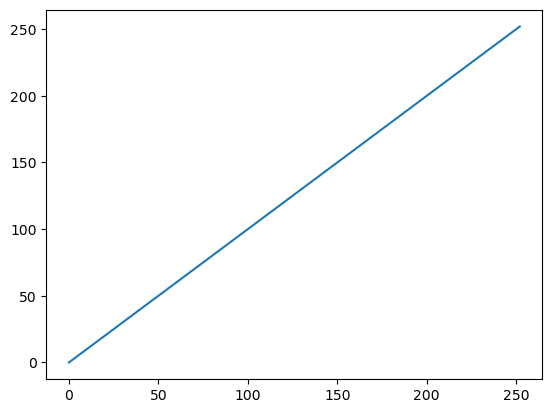

In [906]:
plt.plot(nan_idxs)
len(nan_idxs)

# fk-analysis

In [801]:
# fourier transform for multiple gapless data segments in DASlist

freqres = 0.5 # Hz, interpolate all fts to this frequency resolution    
f_res = np.arange(-int(attrs['PulseRate']/2.)+freqres,int(attrs['PulseRate']/2.)-freqres,freqres)

ft_list = []
data_list_select = [fk_data for fk_data in data_list if fk_data.shape[0]>attrs['PulseRate']/freqres]
# number of data segment longer than 1s
# num_fts = len([1 for fk_data in data_list if fk_data.shape[0]>attrs['PulseRate']])
num_fts = len(data_list_select)
ft_all = np.full((num_fts, len(f_res), data_list[0].shape[1]), 0.+0j)

for i, fk_data in enumerate(data_list_select):
    print("Fourier transform {} of {} calculated.".format(i+1, len(data_list_select)), end="\r")

    if fk_data.shape[0]>attrs['PulseRate']:
        ft = np.fft.fftshift(np.fft.fft2(fk_data))
        f = np.fft.fftshift(np.fft.fftfreq(fk_data.shape[0], d=1/attrs['PulseRate'] * downsample_factor))
        k = np.fft.fftshift(np.fft.fftfreq(fk_data.shape[1], d=attrs['SpatialSamplingInterval']))
        # try:
        interp_func = scipy.interpolate.interp1d(f, ft, axis=0)
        weight = len(fk_data)/len(f_res)
        ft_interp = interp_func(f_res) * weight # weight by length of data
        ft_all[i] = ft_interp

In [802]:
# take the mean of the fourer transforms
ft_stack = np.mean(ft_all, axis=0)

Text(0, 0.5, 'Frequency (Hz)')

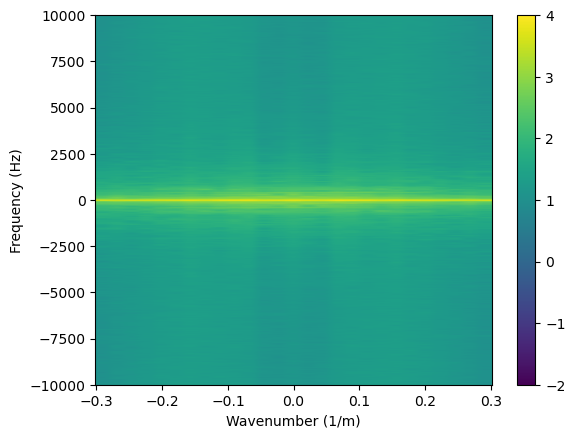

In [803]:
im = plt.imshow(np.log10(np.abs(ft_stack)), 
           aspect='auto',
           origin='lower', 
            extent=[np.min(k), np.max(k), np.min(f_res), np.max(f_res)],
          vmin=-2,
          vmax=4
               )
plt.ylim(-10000,10000)
# plt.xlim(0.023,np.max(k))
# plt.yscale('log')
# plt.xscale('log')
plt.colorbar(im)
plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')